In [24]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    

In [3]:
def LouvainCorrelationClustering(R):   # R is a matrix of return
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)
    DF=pd.DataFrame.from_dict(partition,orient="index")
    DF['StockName'] = R.columns
    DF = DF.reset_index()
    DF = DF.drop(columns = 'index')
    DF = DF.rename({0: 'Cluster'},axis = 'columns')
    DF = DF.set_index('StockName')
    return(DF)

In [4]:
# clust_louvain=LouvainCorrelationClustering(DF_cut)
# print(clust_louvain)
# print(clust_louvain.value_counts()) # 6 clusters

In [5]:
import numpy as np

DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut=DF
display(DF)

sel=DF_cut.isnull().sum(axis=0)>0
DF_cut=DF_cut.drop(columns=DF_cut.columns[sel])
display(DF_cut)

,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,...,NSM,CLP,CTX,CTR,DYN,AIB,KIM,SFN,TCO,S
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16150,0.000305,-0.005420,-0.002896,0.004063,-0.009916,-0.000207,-0.001642,-0.010756,0.006343,-0.000520,...,0.042972,NaN,0.001974,-0.001879,0.011547,0.003892,0.002334,0.011191,0.009188,0.000000
16151,-0.011770,-0.016439,-0.012537,-0.017978,-0.020624,-0.012576,-0.025803,-0.023249,-0.010898,-0.013082,...,-0.011131,NaN,0.007076,-0.006604,-0.008647,-0.001296,0.001863,0.001534,-0.000436,-0.018391
16152,-0.002826,-0.009118,-0.009232,0.001750,0.009959,-0.002304,-0.001688,0.005519,0.000913,0.005253,...,0.047769,NaN,0.007026,0.003307,0.008237,0.003020,0.001395,0.005350,-0.015368,0.018391
16153,0.009568,0.012663,0.019565,0.016351,0.018590,0.002931,0.005055,0.014005,0.009232,0.002616,...,-0.017531,NaN,0.003882,0.007987,0.002458,0.025942,0.000465,0.009860,0.000442,-0.001140


""
0
1
2
3
4
...
16150
16151
16152
16153


## Louvain clustering

In [78]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
#print(clust_louvain)
#print(clust_louvain.value_counts()) # 6 clusters

def drop_nans(df,limit = 0.5):
    """given a dataframe and a limit value, first drops all the columns that have
    more than limit % nans than drops all raws containing at least one nan value"""
    row_num = df.shape[0]
    nan_col = df.isnull().sum(axis=0)>(row_num*limit)
    df=df.drop(columns=df.columns[nan_col])
    return df.dropna()

def pick_n_from_k(df,n,seed = 0,onlynames = False):
    """given a dataframe and a number N, returns a dataframe that 
    contains n randomly selected columns of the input dataframe"""
    
    k = df.shape[0]
    
    #safety check
    assert k >= n, 'K should be >= N'
    
    #if onlynames is active return only the name of the columns
    if onlynames:
        random.seed(seed)
        return random.sample(list(df.columns), n)
    return df.sample(n=n, random_state=seed, axis='columns')

def bootstrap_CI(data, nbr_draws):
    """Given an array and a number of random samples performs bootstrapping to
    find the confidence intervals of the mean"""
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]

    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 0.5),np.nanpercentile(means, 99.5)]

def optimalWeights(df,verbose = False):
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        return ef.portfolio_performance(verbose=True)
    return cleaned_weights

def compute_clusters_returns(df,clusters):
    """given a dataframe and his clusters compute the clusters means"""
    means = df.transpose()
    means = pd.merge(means, clusters,left_index = True, right_on='StockName')
    means = means.groupby('Cluster').mean().transpose()
    return means

def compute_portfolio_return(df,clustering = 'louvian',strategy ='equal weight'):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    if strategy == 'equal weight':
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            cluster_means = compute_clusters_returns(df,clusters)
            portfolio_mean = cluster_means.mean().mean()
            return portfolio_mean
    elif strategy == 'markovitz':
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            cluster_means = compute_clusters_returns(df,clusters)
            #print('Moor:',optimalWeights(df,verbose = True))
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean
        #no clustering only markovitz portfolio
        elif clustering == 'NO':
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean
            
def compute_stategy_avg_return(df,n,n_picks,clustering = 'louvian',strategy ='equal weight'):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    portfolio_returns = []
    for i in range(n_picks):
        sub_df = pick_n_from_k(df,n,seed = (i+1))
#         print(list(sub_df.columns))
        portfolio_return = compute_portfolio_return(sub_df,clustering = clustering,strategy = strategy)
        print('portfolio nb: ',i, 'return: ',portfolio_return)
        portfolio_returns.append(portfolio_return)
    portfolio_returns_mean = sum(portfolio_returns)/len(portfolio_returns)
    CI = bootstrap_CI(portfolio_returns,int(n_picks/1.5))
    yerr = [-(CI[0]-portfolio_returns_mean),CI[1]-portfolio_returns_mean]
#     print(portfolio_returns_mean)
    plt.errorbar(1,portfolio_returns_mean,yerr = np.array(yerr).reshape(2,1), fmt='.', ecolor = 'red')
    plt.ylabel("Mean return of clustering method :" + clustering)
    plt.title("Mean return of clustering method with confidence intervals")
    return portfolio_returns_mean,CI

In [79]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF = drop_nans(DF)
#display(DF)

portfolio nb:  0 return:  0.00047225633339699876
portfolio nb:  1 return:  0.0004466893670863533
portfolio nb:  2 return:  0.0005444585291142458
portfolio nb:  3 return:  0.0004963397922361476
portfolio nb:  4 return:  0.0004887872381227138
portfolio nb:  5 return:  0.00050210260838584
portfolio nb:  6 return:  0.0005037674744196411
portfolio nb:  7 return:  0.0004931000813693502
portfolio nb:  8 return:  0.0004955961368051779
portfolio nb:  9 return:  0.00048795614378858065
strategy mean:  (0.000493105370472505, [0.0004920521666162774, 0.0005117690055433661])


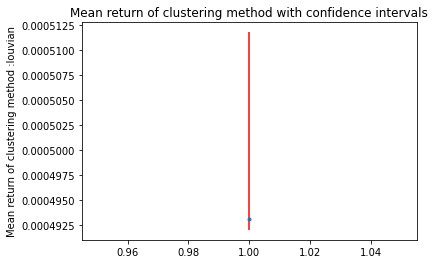

In [80]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10))

Expected annual return: 15.2%
Annual volatility: 17.0%
Sharpe Ratio: 0.78
portfolio nb:  0 return:  0.1524700176827279
Expected annual return: 20.4%
Annual volatility: 19.0%
Sharpe Ratio: 0.97
portfolio nb:  1 return:  0.204080508460139
Expected annual return: 19.7%
Annual volatility: 17.4%
Sharpe Ratio: 1.02
portfolio nb:  2 return:  0.19716021174467618
Expected annual return: 20.2%
Annual volatility: 17.9%
Sharpe Ratio: 1.02
portfolio nb:  3 return:  0.20204718865647003
Expected annual return: 19.6%
Annual volatility: 17.2%
Sharpe Ratio: 1.02
portfolio nb:  4 return:  0.19574706489851992
Expected annual return: 17.4%
Annual volatility: 16.6%
Sharpe Ratio: 0.93
portfolio nb:  5 return:  0.17414663073154096
Expected annual return: 17.2%
Annual volatility: 17.2%
Sharpe Ratio: 0.88
portfolio nb:  6 return:  0.1717986651094257
Expected annual return: 19.5%
Annual volatility: 17.6%
Sharpe Ratio: 0.99
portfolio nb:  7 return:  0.19490158192475046
Expected annual return: 19.6%
Annual volatil

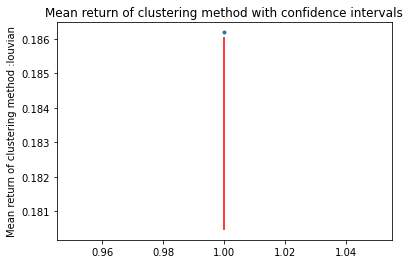

In [82]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,strategy = 'markovitz'))

Expected annual return: 15.2%
Annual volatility: 17.0%
Sharpe Ratio: 0.78
portfolio nb:  0 return:  0.1524700176827279
Expected annual return: 20.4%
Annual volatility: 19.0%
Sharpe Ratio: 0.97
portfolio nb:  1 return:  0.204080508460139
Expected annual return: 19.7%
Annual volatility: 17.4%
Sharpe Ratio: 1.02
portfolio nb:  2 return:  0.19716021174467618
Expected annual return: 20.2%
Annual volatility: 17.9%
Sharpe Ratio: 1.02
portfolio nb:  3 return:  0.20204718865647003
Expected annual return: 19.6%
Annual volatility: 17.2%
Sharpe Ratio: 1.02
portfolio nb:  4 return:  0.19574706489851992
Expected annual return: 17.4%
Annual volatility: 16.6%
Sharpe Ratio: 0.93
portfolio nb:  5 return:  0.17414663073154096
Expected annual return: 17.2%
Annual volatility: 17.2%
Sharpe Ratio: 0.88
portfolio nb:  6 return:  0.1717986651094257
Expected annual return: 19.5%
Annual volatility: 17.6%
Sharpe Ratio: 0.99
portfolio nb:  7 return:  0.19490158192475046
Expected annual return: 19.6%
Annual volatil

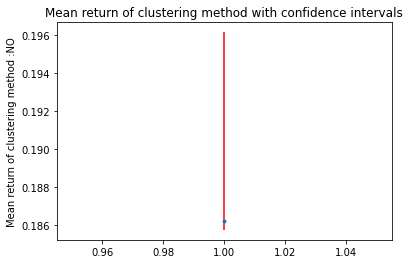

In [83]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,clustering = 'NO',strategy = 'markovitz'))

## Maximum likelihood clustering



There is no code for this method in Python. The following shows how to call R from Python.

In [76]:
!pip install rpy2 -U

Requirement already up-to-date: rpy2 in c:\users\mauro\anaconda3\lib\site-packages (3.4.5)


In [77]:
# first install R https://cran.rstudio.com/
# # run this cell the first time you use rpy2 only.

from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages("data.table")
 

--- Per piacere, seleziona un mirror CRAN per la sessione ---


From cffi callback <function _consolewrite_ex at 0x00000183501BB828>:
Traceback (most recent call last):
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 78: invalid continuation byte
R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/bin/windows/contrib/4.1/data.table_1.14.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2600662 bytes (2.5 MB)

R[write to console]: downloaded 2.5 MB




package 'data.table' successfully unpacked and MD5 sums checked


R[write to console]: Warning:
R[write to console]:  cannot remove prior installation of package 'data.table'

R[write to console]: Warning:
R[write to console]:  restored 'data.table'




The downloaded binary packages are in
	C:\Users\mauro\AppData\Local\Temp\RtmpIDP8UX\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x00000183502A1F08> [RTYPES.NILSXP]

In [78]:
import rpy2.robjects as robjects
r = robjects.r

#importr("data.table")
newfunc = r.source("""libClusteringGiadaMarsiliFast.R""")
aggregateClusters=robjects.globalenv["aggregateClusters"]   # now aggregateClusters is a Python function


R[write to console]: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In file.copy(savedcopy, lib, recursive = TRUE) :
R[write to console]: 
 
R[write to console]:  problem copying C:\Users\mauro\Documents\R\win-library\4.1\00LOCK\data.table\libs\x64\datatable.dll to C:\Users\mauro\Documents\R\win-library\4.1\data.table\libs\x64\datatable.dll: Permission denied

R[write to console]: 2: 
R[write to console]: In file(filename, "r", encoding = encoding) :
R[write to console]: 
 
R[write to console]:  cannot open file 'libClusteringGiadaMarsiliFast.R': No such file or directory



RRuntimeError: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection


In [28]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

C=DF_cut.corr()


In [31]:
clust_ML=aggregateClusters(C.values)

NameError: name 'aggregateClusters' is not defined

In [ ]:
clust_ML[3]   # this is a dictionary (List in the R language) which contains the membership of each cluster, one cluster at a time

In [ ]:
np.array(clust_ML[3][0]) # first cluster

In [ ]:
pd.DataFrame(np.array(clust_ML.rx["s_i"][0]).flatten()).value_counts() # 49 clusters, of highly heterogeneous size